In [1]:
import geopandas as gpd
import geoplot
import wget
from glob import glob
import zipfile
import pandas as pd
import pyarrow.parquet as pq
import os
from timeit import default_timer as timer
import folium
import socket
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
from folium.plugins import HeatMap
import branca.colormap
from collections import defaultdict
import webbrowser
import matplotlib.colors as colors

try:
    get_ipython().magic('matplotlib inline')
    print('Figures Inline')
except:
    import matplotlib
    matplotlib.use('Agg')
    print('Figures Backend')

Figures Inline


In [2]:
print('Hostname:', socket.gethostname())
if 'samuel' in socket.gethostname().lower():
    path_to_data='../../data'
else:
    path_to_data='/scratch/spf248/twitter/data'
    
path_to_shp=os.path.join(path_to_data,'shp')
path_to_fig=os.path.join(path_to_data,'../fig')
# path_to_fig='./'
path_to_tweets=os.path.join(path_to_data,'tweets/tweets-with-geocoordinates-or-place')
country_gis='PAK'
level_gis=3
url_root='http://biogeo.ucdavis.edu/data/diva/adm'
country_twitter='PK'
start_date='2012/01/01'
end_date='2016/12/31'

print('Country:', country_twitter)

Hostname: c41-10
Country: PK


In [3]:
if os.path.exists(os.path.join(path_to_shp,country_gis+'_adm.zip')):
    print('Shapefiles exist')
else:
    print('Download shapefiles')
    filename=wget.download(os.path.join(url_root,country_gis+'_adm.zip'),out=path_to_shp)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(filename.replace('.zip',''))

print('Load shapefiles')
shp=gpd.read_file(os.path.join(path_to_shp,country_gis+'_adm',country_gis+'_adm'+str(level_gis)+'.shp'))

Shapefiles exist
Load shapefiles


In [4]:
print('Load Geolocated df with Identified Location...')
start = timer()

filenames=sorted(glob(os.path.join(path_to_tweets,'identified','*.parquet')))

tweets=pd.DataFrame()

for i,filename in enumerate(filenames):
    
    print(filename)
    
    df=pd.read_parquet(filename)
    print('# Tweets:', df.shape[0])
    print('# Users:',df['user_id'].unique().shape[0])

    df=df[df.rg_cc==country_twitter].copy()
    print('# Tweets in',country_twitter,':',df.shape[0])
    print('# Users in',country_twitter,':',df['user_id'].unique().shape[0])

    df=df[(df.created_at>start_date)&(df.created_at<end_date)].copy()
    print('# Tweets in',country_twitter,start_date,end_date,':',df.shape[0])
    print('# Users in',country_twitter,start_date,end_date,':',df['user_id'].unique().shape[0])
    
    tweets=pd.concat([tweets,df],sort=False)
    
#     if i > 1:
#         break
    
tweets=gpd.GeoDataFrame(tweets,geometry=gpd.points_from_xy(tweets.tweet_longitude, tweets.tweet_latitude))
tweets.crs={'init': 'epsg:4326'}

del df

end = timer()
print('Computing Time:', round(end - start), 'sec')

Load Geolocated df with Identified Location...
/scratch/spf248/twitter/data/tweets/tweets-with-geocoordinates-or-place/identified/part-00000-03c0ffb0-8b12-49dc-9de0-28ec5a1de92a-c000.snappy.parquet
# Tweets: 0
# Users: 0
# Tweets in PK : 0
# Users in PK : 0
# Tweets in PK 2012/01/01 2016/12/31 : 0
# Users in PK 2012/01/01 2016/12/31 : 0
/scratch/spf248/twitter/data/tweets/tweets-with-geocoordinates-or-place/identified/part-00001-03c0ffb0-8b12-49dc-9de0-28ec5a1de92a-c000.snappy.parquet
# Tweets: 1150425
# Users: 830110
# Tweets in PK : 1324
# Users in PK : 949
# Tweets in PK 2012/01/01 2016/12/31 : 1283
# Users in PK 2012/01/01 2016/12/31 : 924
/scratch/spf248/twitter/data/tweets/tweets-with-geocoordinates-or-place/identified/part-00004-03c0ffb0-8b12-49dc-9de0-28ec5a1de92a-c000.snappy.parquet
# Tweets: 1147874
# Users: 828773
# Tweets in PK : 1397
# Users in PK : 986
# Tweets in PK 2012/01/01 2016/12/31 : 1362
# Users in PK 2012/01/01 2016/12/31 : 967
Computing Time: 9 sec


In [5]:
print('Dissolve...')
start = timer()

print('# Tweets:', tweets.shape[0])
print('# Users:', tweets['user_id'].unique().shape[0])

df=gpd.sjoin(shp,tweets[[
'tweet_id',
'tweet_lang',
'user_id',
'geometry',
]],how='left').dissolve(
by='ID_'+str(level_gis),aggfunc={
'NAME_'+str(level_gis):'first',
'tweet_id':'count',
'user_id':'nunique'})

end = timer()
print('Computing Time:', round(end - start), 'sec')

Dissolve...
# Tweets: 2645
# Users: 1646
Computing Time: 84 sec


In [6]:
tweets.head()

,user_location,tweet_id,created_at,text,tweet_lang,user_id,place_id,tweet_longitude,tweet_latitude,rg_name,rg_admin1,rg_admin2,rg_cc,geometry
46436,Pakistan,158150380759425024,2012-01-14 11:36:03,"I'm at Cinnabon Bakery Cafe (2B/3 Gulberg 3, M...",None,69658748,None,74.353634,31.506914,Lahore,Punjab,,PK,POINT (74.35363 31.50691)
46852,"karachi, Pakistan",158530199930146816,2012-01-15 12:45:19,@Pricey_AFC #followback #Arsenal,None,14378402,None,67.028965,24.871168,Karachi,Sindh,Karachi District,PK,POINT (67.02897 24.87117)
49512,"karachi, Pakistan",161074024544342016,2012-01-22 13:13:34,@parasabbasi :(,None,14378402,None,67.028965,24.871168,Karachi,Sindh,Karachi District,PK,POINT (67.02897 24.87117)
64047,Pakistan,174155765089705984,2012-02-27 15:35:44,Twitter for Android is not changing my DP even...,None,116461726,None,74.289679,31.480539,Lahore,Punjab,,PK,POINT (74.28968 31.48054)
65251,pakistan,175263153758814211,2012-03-01 16:56:06,@IANMHARDING how can you be SO mean?,None,49428339,None,74.333711,31.549595,Lahore,Punjab,,PK,POINT (74.33371 31.54959)


# Figures

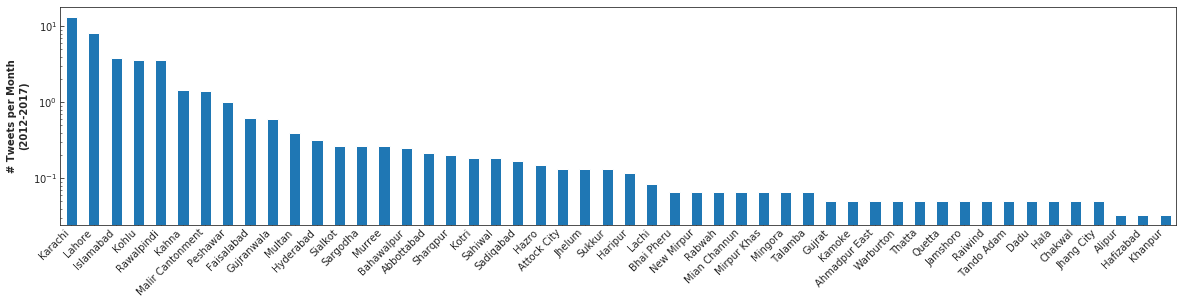

In [7]:
with sns.axes_style("white"):
    sns.set_style("ticks")

    fig,ax = plt.subplots(figsize=(20,4))
    data_to_plot=1./(12*5)*tweets['rg_name'].value_counts().head(50)
    data_to_plot.plot(ax=ax,kind='bar')
    ax.set_ylabel('# Tweets per Month\n(2012-2017)',fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
    ax.set_yscale('log')
    
plt.savefig(os.path.join(path_to_fig,'most-active-localities-pakistan-2012-2017.pdf'),bbox_inches='tight')

In [8]:
def languagecode2name(x):
    if x=='in':
        return 'Indic language'
    elif x == 'und':
        return 'Undetermined'
    else:
        try:
            return pycountry.languages.get(alpha_2=x).name
        except:
            return ''

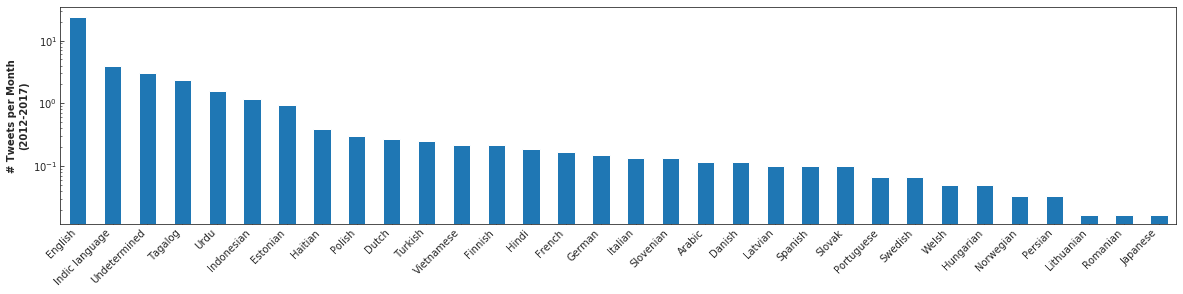

In [9]:
with sns.axes_style("white"):
    sns.set_style("ticks")

    fig,ax = plt.subplots(figsize=(20,4))
    data_to_plot=(1./(12*5)*tweets['tweet_lang'].value_counts().head(50))
    data_to_plot.index=data_to_plot.index.map(languagecode2name)
    data_to_plot.plot(ax=ax,kind='bar')
    ax.set_ylabel('# Tweets per Month\n(2012-2017)',fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
    ax.set_yscale('log')
    
plt.savefig(os.path.join(path_to_fig,'most-active-languages-pakistan-2012-2017.pdf'),bbox_inches='tight')

In [10]:
queries=[
'Abbottabad',
'Bajaur Agency',
'Bannu',
'Batagram',
'Buner',
'Charsadda',
'Chitral',
'Dera Ismail Khan',
'Erstwhile FATA',
'Ex-FATA',
'F.A.T.A.',
'FR Bannu',
'FR Dera Ismail Khan',
'FR Kohat',
'FR Lakki Marwat',
'FR Peshawar',
'FR Tank',
'Federally Administrated Tribal Areas (FATA)',
'Frontier Region (FR)',
'Hangu',
'Haripur',
'Karak',
'Khyber Pakhtun Khwa (KPK)',
'Khyber Pakhtunkhwa',
'Kohat',
'Kohistan',
'Kurram Agency',
'Kyber Agency',
'Lakki Marwat',
'Lower Dir',
'Malakand',
'Mansehra',
'Mardan',
'Merged Areas',
'Merged Districts',
'Mohmand Agency',
'N.W.F.P.',
'North Waziristan Agency',
'North Western Frontier Region (N.W.F.R)',
'Nowshera',
'Orakzai Agency',
'Peshawar',
'Shangla',
'South Waziristan Agency',
'Swabi',
'Swat',
'Tank',
'Torghar',
'Upper Dir']

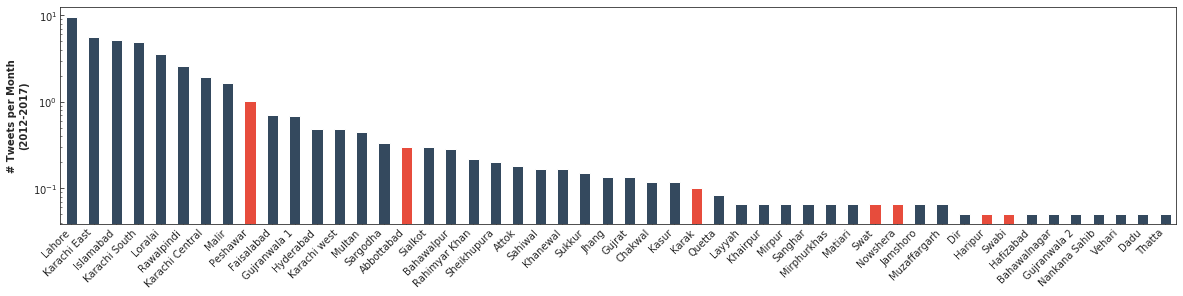

In [11]:
with sns.axes_style("white"):
    sns.set_style("ticks")

    fig,ax = plt.subplots(figsize=(20,4))
    data_to_plot=(1./(12*5)*df.set_index('NAME_'+str(level_gis))['tweet_id'].sort_values(ascending=False)).head(50)
    data_to_plot.plot(
    ax=ax,
    kind='bar',
    color=data_to_plot.index.map(lambda x:"#34495e" if not int(x in queries) else "#e74c3c"))
    ax.set_ylabel('# Tweets per Month\n(2012-2017)',fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(which='both',direction='in',pad=3)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
    ax.set_yscale('log')
    
plt.savefig(os.path.join(path_to_fig,'most-active-districts-pakistan-2012-2017.pdf'),bbox_inches='tight')

http://geopandas.org/gallery/plotting_with_geoplot.html

/home/spf248/pyenv/py3.7-20200205/lib/python3.7/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/spf248/pyenv/py3.7-20200205/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: setting k to 7
  Warn("Warning: setting k to %d" % k_q, UserWarning)


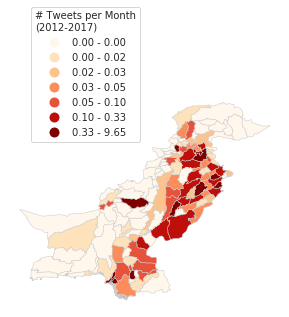

In [12]:
with sns.axes_style("white"):
    sns.set_style("ticks")
    
    fig,ax = plt.subplots(figsize=(40,4))

    data_to_plot=df[['tweet_id','geometry']].copy()
    data_to_plot['tweet_id']=data_to_plot['tweet_id']*1./(12*5)

    data_to_plot.plot(
    'tweet_id',
    scheme='Quantiles',
    linewidth=0.5, 
    k=10,
    ax=ax, 
    cmap='OrRd',
    edgecolor='0.8',
    legend=True,
    legend_kwds={
    'frameon': True, 
    'title': '# Tweets per Month\n(2012-2017)',
    'loc': 'lower right',
    'bbox_to_anchor':(0.5, 0.75), 
    'frameon':'False',
    })
    ax.axis('off')
          
plt.savefig(os.path.join(path_to_fig,'map-districts-activity-pakistan-2012-2017.pdf'),bbox_inches='tight')

/home/spf248/pyenv/py3.7-20200205/lib/python3.7/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/spf248/pyenv/py3.7-20200205/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: setting k to 8
  Warn("Warning: setting k to %d" % k_q, UserWarning)


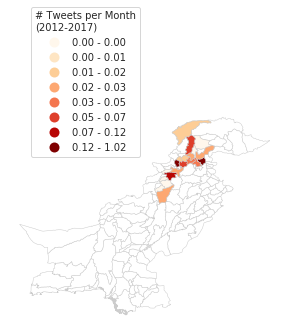

In [13]:
with sns.axes_style("white"):
    sns.set_style("ticks")
    
    fig,ax = plt.subplots(figsize=(40,4))

    data_to_plot=df.set_index('NAME_'+str(level_gis))[['tweet_id','geometry']].dropna().copy()
    data_to_plot['tweet_id']=data_to_plot['tweet_id']*1./(12*5)

    data_to_plot.plot(
    linewidth=0.5, 
    color='white',
    edgecolor='0.8',
    ax=ax,
    )
    
    data_to_plot=data_to_plot.reindex(queries)[['tweet_id','geometry']].dropna().copy()
    
    data_to_plot.plot(
    'tweet_id',
    scheme='Quantiles',
    linewidth=0.5, 
    k=10,
    ax=ax, 
    cmap='OrRd',
    edgecolor='0.8',
    legend=True,
    legend_kwds={
    'frameon': True, 
    'title': '# Tweets per Month\n(2012-2017)',
    'loc': 'lower right',
    'bbox_to_anchor':(0.5, 0.75), 
    'frameon':'False',
    })
    ax.axis('off')
          
plt.savefig(os.path.join(path_to_fig,'map-selected-districts-activity-pakistan-2012-2017.pdf'),bbox_inches='tight')

https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf

In [14]:
base_map=folium.Map(
location=[tweets.tweet_latitude.mean(), tweets.tweet_longitude.mean()], 
control_scale=True, 
zoom_start=6, 
tiles='cartodbpositron')

# Add heat map to the previously created map
HeatMap(
tweets.groupby(['tweet_latitude', 'tweet_longitude'])['tweet_id'].count().reset_index().values.tolist(), 
radius=8, 
max_zoom=13).add_to(base_map)

base_map.save(os.path.join(path_to_fig,'interactive-map-activity-pakistan-2012-2017.html'))

In [15]:
base_map